TODO: 
* Write a proper description
* Create 00- part for hypergraph creation

# Vectorizers on Hypergraphs

Unlike the recipe notebook, here we wish to classify the vertices *not* the hyperedges. In order to do so, we want to work on the dual. So first, we want to 

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# from src import paths
# from src.data import Dataset
# from src.user.viz import topic_word_by_class, topic_word_by_cluster

In [3]:
import hdbscan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.feature_extraction.text
import sklearn.preprocessing
import scipy.sparse
import vectorizers
import vectorizers.transformers
import umap
import umap.plot
import pynndescent
import seaborn as sns
import matplotlib.colors
import warnings
from bokeh.plotting import show
from sklearn.metrics import adjusted_rand_score

umap.plot.output_notebook()
warnings.simplefilter("ignore")
sns.set()


Loading BokehJS ...

In [4]:
def TokenSetCooccurrenceVectorizer(hyperedges):
    long_list = max(len(x) for x in hyperedges)
    vertex_vectorizer_before = vectorizers.TokenCooccurrenceVectorizer(
        min_document_occurrences=1,
        window_radii=long_list,          
        window_functions='fixed',
        kernel_functions='flat',            
        n_iter = 0,
        window_orientations='before',
        normalize_windows=True,
    ).fit(hyperedges)

    vertex_vectorizer_after = vectorizers.TokenCooccurrenceVectorizer(
        min_document_occurrences=1,
        window_radii=long_list,          
        window_functions='fixed',
        kernel_functions='flat',            
        n_iter = 0,
        window_orientations='after',
        normalize_windows=True,
    ).fit(hyperedges)
    
    vertex_vectorizer_all = vertex_vectorizer_after
    vertex_vectorizer_all.cooccurrences_ = vertex_vectorizer_before.cooccurrences_ + vertex_vectorizer_after.cooccurrences_
    return(vertex_vectorizer_all)

## Trivago

In [5]:
# This example is the first one suggested in the README file of the package
file_vertex_labels = '../data/trivago-clicks/node-labels-trivago-clicks.txt'
file_hyperedges = '../data/trivago-clicks/hyperedges-trivago-clicks.txt'
label_mapping_file = '../data/trivago-clicks/label-names-trivago-clicks.txt'

In [6]:
with open(file_hyperedges, 'r') as file:
    # Read all the lines of the file into a list
    lines = file.readlines()
hyperedges_all = [[int(y) for y in x.replace('\n','').split(',')] for x in lines]

In [7]:
with open(file_vertex_labels, 'r') as file:
    # Read all the lines of the file into a list
    vertex_labels = np.array([int(y) for y in file.read().splitlines()])

In [8]:
len(vertex_labels)

172738

In [9]:
with open(label_mapping_file, 'r') as file:
    # Read all the lines of the file into a list
    lines = file.readlines()
label_names = [x.replace('\n','') for x in lines]

### Removing large hyperedges

If hyperedges have size larger than 20 they are removed. We therefore remove 402 of the total number of hyperedge.

In [10]:
hyperedges = [x for x in hyperedges_all if len(x) <= 20]

In [11]:
len(hyperedges_all)

233202

In [12]:
len(hyperedges)

232800

### Node degree

In [13]:
from collections import Counter
v_degrees = Counter([i for v in hyperedges for i in v])

In [14]:
v_degrees.most_common(10)

[(31578, 338),
 (84466, 300),
 (147235, 296),
 (170111, 293),
 (33957, 288),
 (53856, 284),
 (93615, 272),
 (23877, 271),
 (68656, 268),
 (136810, 240)]

In [ ]:
vectorizers.MultiSetCooccurrenceVectorizer()

# Vectorize vertices

In [54]:
%%time
vertex_vectorizer = TokenSetCooccurrenceVectorizer(hyperedges)
vertex_vectors = vertex_vectorizer.reduce_dimension(dimension=120, algorithm="randomized")

CPU times: user 3min 32s, sys: 11.2 s, total: 3min 44s
Wall time: 1min 44s


In [23]:
len(hyperedges)

232800

In [49]:
%%time
multiset_vectorizer_norm = vectorizers.MultiSetCooccurrenceVectorizer(
    window_radii=0,
    window_orientations='before',
    normalize_windows=True,
    n_iter = 0
).fit([hyperedges])

CPU times: user 3.64 s, sys: 32 ms, total: 3.67 s
Wall time: 3.67 s


In [50]:
%%time
multiset_vectorizer_0_no_norm = vectorizers.MultiSetCooccurrenceVectorizer(
    window_radii=0,
    window_orientations='before',
    normalize_windows=False,
    n_iter = 0
).fit([hyperedges])

CPU times: user 3.42 s, sys: 52 ms, total: 3.48 s
Wall time: 3.48 s


In [44]:
%%time
multiset_vectorizer_0 = vectorizers.MultiSetCooccurrenceVectorizer(
    window_radii=0,
    window_orientations='before',
    normalize_windows=True,
    n_iter = 0
).fit([hyperedges])

multiset_vectorizer_1 = vectorizers.MultiSetCooccurrenceVectorizer(
    window_radii=0,
    window_orientations='before',
    normalize_windows=True,
    n_iter = 1
).fit([hyperedges])

multiset_vectorizer_3 = vectorizers.MultiSetCooccurrenceVectorizer(
    window_radii=0,
    window_orientations='before',
    normalize_windows=True,
    n_iter = 3
).fit([hyperedges])

multiset_vectorizer_5 = vectorizers.MultiSetCooccurrenceVectorizer(
    window_radii=0,
    window_orientations='before',
    normalize_windows=True,
    n_iter = 5
).fit([hyperedges])

multiset_vectorizer_10 = vectorizers.MultiSetCooccurrenceVectorizer(
    window_radii=0,
    window_orientations='before',
    normalize_windows=True,
    n_iter = 10
).fit([hyperedges])

multiset_vectorizer_15 = vectorizers.MultiSetCooccurrenceVectorizer(
    window_radii=0,
    window_orientations='before',
    normalize_windows=True,
    n_iter = 15
).fit([hyperedges])

multiset_vectorizer_20 = vectorizers.MultiSetCooccurrenceVectorizer(
    window_radii=0,
    window_orientations='before',
    normalize_windows=True,
    n_iter = 20
).fit([hyperedges])

CPU times: user 2min 5s, sys: 396 ms, total: 2min 5s
Wall time: 2min 5s


In [45]:
ax = 0
print(multiset_vectorizer_0.cooccurrences_.sum(axis=ax))
print(multiset_vectorizer_1.cooccurrences_.sum(axis=ax))
print(multiset_vectorizer_3.cooccurrences_.sum(axis=ax))
print(multiset_vectorizer_5.cooccurrences_.sum(axis=ax))
print(multiset_vectorizer_10.cooccurrences_.sum(axis=ax))
print(multiset_vectorizer_15.cooccurrences_.sum(axis=ax))
print(multiset_vectorizer_20.cooccurrences_.sum(axis=ax))

[[5.9999995 6.        4.9999995 ... 5.0000005 1.        4.0000005]]
[[1.         1.         1.         ... 1.         0.99999994 1.0000001 ]]
[[1.         0.9999999  1.         ... 0.9999999  1.         0.99999994]]
[[1.0000001  0.9999999  0.99999994 ... 1.         1.         0.99999994]]
[[1.         1.         1.         ... 1.0000001  1.         0.99999994]]
[[1.0000001 1.        1.        ... 1.0000001 1.        1.       ]]
[[1.         1.         0.99999994 ... 0.99999994 0.99999994 1.        ]]


In [46]:
ax = 1
print(multiset_vectorizer_0.cooccurrences_.sum(axis=ax))
print(multiset_vectorizer_1.cooccurrences_.sum(axis=ax))
print(multiset_vectorizer_3.cooccurrences_.sum(axis=ax))
print(multiset_vectorizer_5.cooccurrences_.sum(axis=ax))
print(multiset_vectorizer_10.cooccurrences_.sum(axis=ax))
print(multiset_vectorizer_15.cooccurrences_.sum(axis=ax))
print(multiset_vectorizer_20.cooccurrences_.sum(axis=ax))

[[6.       ]
 [5.9999995]
 [4.9999995]
 ...
 [5.       ]
 [1.       ]
 [4.0000005]]
[[1.4427559 ]
 [2.6026077 ]
 [2.3405    ]
 ...
 [0.9523123 ]
 [0.69132507]
 [0.8103056 ]]
[[1.4631921 ]
 [2.5605023 ]
 [2.2809463 ]
 ...
 [0.90884435]
 [0.66925955]
 [0.8481158 ]]
[[1.4838587 ]
 [2.566305  ]
 [2.2738051 ]
 ...
 [0.8647541 ]
 [0.65562856]
 [0.85019547]]
[[1.5150071 ]
 [2.5740852 ]
 [2.2757206 ]
 ...
 [0.8304458 ]
 [0.6405349 ]
 [0.86043555]]
[[1.5266515 ]
 [2.5811577 ]
 [2.2885714 ]
 ...
 [0.8240096 ]
 [0.6361503 ]
 [0.87115747]]
[[1.5291607 ]
 [2.588068  ]
 [2.3015857 ]
 ...
 [0.8214542 ]
 [0.63520044]
 [0.8778059 ]]


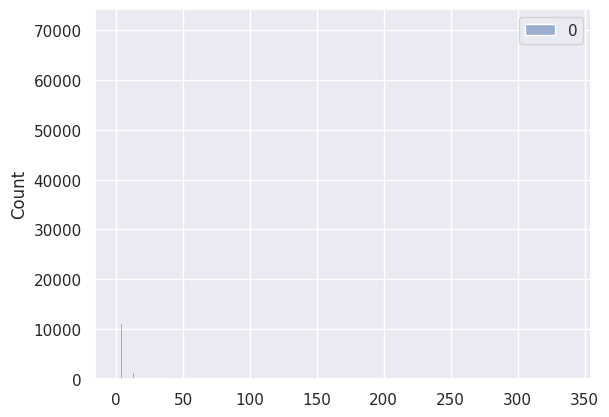

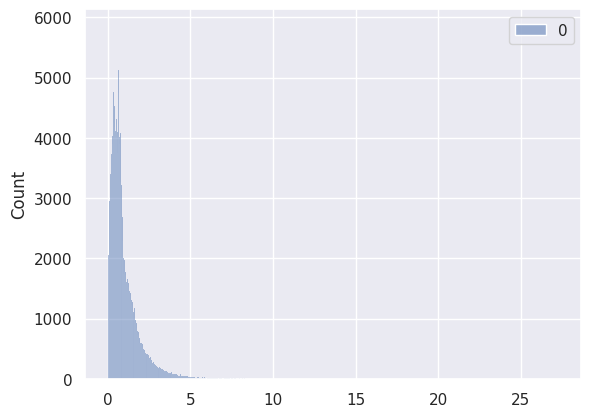

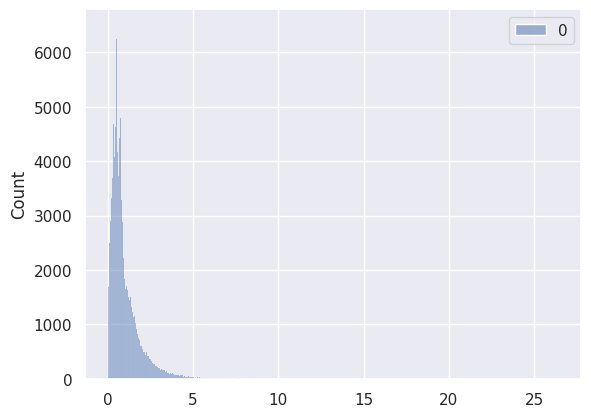

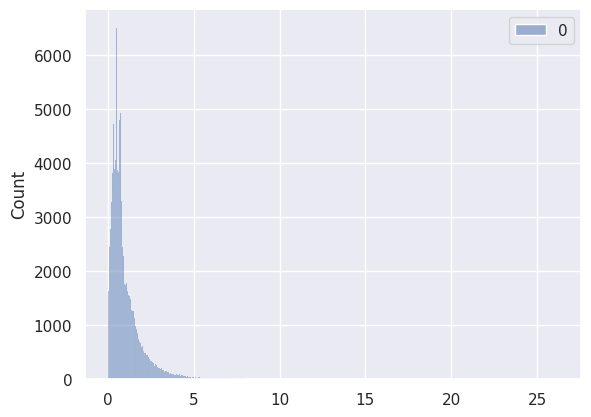

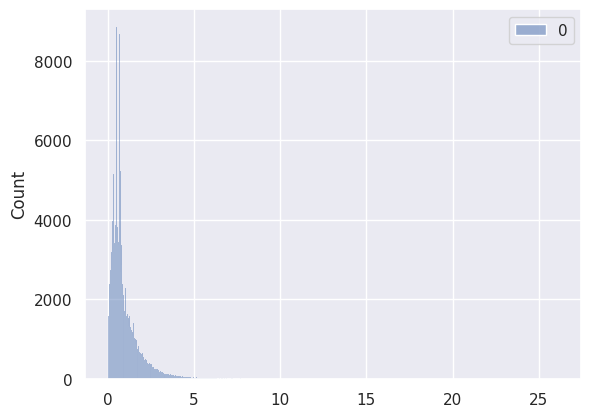

In [48]:
sns.histplot(multiset_vectorizer_0.cooccurrences_.sum(axis=ax))
plt.show()
sns.histplot(multiset_vectorizer_1.cooccurrences_.sum(axis=ax))
plt.show()
sns.histplot(multiset_vectorizer_3.cooccurrences_.sum(axis=ax))
plt.show()
sns.histplot(multiset_vectorizer_5.cooccurrences_.sum(axis=ax))
plt.show()
# sns.histplot(multiset_vectorizer_10.cooccurrences_.sum(axis=ax))
# plt.show()
# sns.histplot(multiset_vectorizer_15.cooccurrences_.sum(axis=ax))
# plt.show()
sns.histplot(multiset_vectorizer_20.cooccurrences_.sum(axis=ax))
plt.show()

In [30]:
vertex_vectorizer.cooccurrences_.data

array([0.21111111, 1.        , 0.1       , ..., 0.05263158, 0.05263158,
       0.05263158], dtype=float32)

In [33]:
multiset_vectorizer.cooccurrences_.data

array([0.21111111, 1.        , 0.1       , ..., 0.05263158, 0.05263158,
       0.05263158], dtype=float32)

In [28]:
multiset_vectorizer

'post_0_170958'

In [15]:
# %%time
# long_list = max(len(x) for x in hyperedges)
# vertex_vectorizer = vectorizers.TokenCooccurrenceVectorizer(
#     min_document_occurrences=1,
#     window_radii=long_list,          
#     window_functions='fixed',
#     kernel_functions='flat',            
#     n_iter = 0,
#     normalize_windows=True,
# ).fit(hyperedges)
# vertex_vectors = vertex_vectorizer.reduce_dimension(dimension=256, algorithm="randomized")

CPU times: user 3min 52s, sys: 15.3 s, total: 4min 8s
Wall time: 1min 23s


In [16]:
%%time
vertex_mapper = umap.UMAP(n_neighbors=8, metric = 'cosine', random_state=42).fit(vertex_vectors)

NameError: name 'vertex_vectors' is not defined

In [15]:
# hdbscan_labels = hdbscan.HDBSCAN(min_cluster_size=30).fit_predict(vertex_mapper.embedding_)

In [16]:
# from collections import Counter
# Counter(hdbscan_labels)

In [17]:
# adjusted_rand_score(hdbscan_labels[hdbscan_labels!=-1], vertex_labels[hdbscan_labels!=-1])

In [ ]:
p = umap.plot.points(
    vertex_mapper,
    labels=np.array(vertex_labels),
    background="black",
    width=1024,
    height=1024,
    show_legend=False
);

In [ ]:
hover_data=pd.DataFrame()
hover_data['vocab'] = [vertex_vectorizer.token_index_dictionary_[x] 
                       for x in range(len(vertex_vectorizer.token_index_dictionary_))]

p = umap.plot.interactive(
    vertex_mapper, 
    hover_data=hover_data, 
    labels=vertex_labels,
    point_size=5, 
    # values=np.log(vertex_vectorizer._token_frequencies_), 
    interactive_text_search=True, 
    interactive_text_search_alpha_contrast=0.99)
show(p)

# Hyperedge as vocabulary

We start by embedding hyperedges as vocabulary elements. The vertices will then be considered as a *bag of hyperedges* they are part of.

In [39]:
n = len(vertex_labels)
n

10000

In [40]:
# Get the dual hypergraph as a list of lists
vertex_dict = dict()
for i in range(1, n+1):
    vertex_dict[i] = []
for i, he in enumerate(hyperedges):
    for v in he:
        vertex_dict[v].append(i)

In [41]:
# The dual has one list per vertex
dual_hyperedges = [vertex_dict[i] for i in range(1, n+1)]

In [42]:
len(dual_hyperedges)

10000

In [43]:
%%time
long_list = max(len(x) for x in dual_hyperedges)
he_vectorizer = vectorizers.TokenCooccurrenceVectorizer(
    min_document_occurrences=1,
    window_radii=long_list,          
    window_functions='fixed',
    kernel_functions='flat',            
    n_iter = 0,
    normalize_windows=True,
).fit(dual_hyperedges)
he_vectors = he_vectorizer.reduce_dimension(dimension=60, algorithm="randomized")

CPU times: user 18.7 s, sys: 5.5 s, total: 24.2 s
Wall time: 10.9 s


In [44]:
he_vectors.shape

(21680, 60)

----
## Vertex Embedding

There are 3 steps to obtain the Approximate Wasserstein recipe embedding: 
1. **Vertex(bag-of-hyperedge) Embedding** via `NgramVectorizer`: This step uses a bag-of-words approach to vectorize documents. 
2. **Information Weight Embedding** via `InformationWeightTransformer`: This step takes an information theoretic view to generating feature weights for count data (inspired by TF-IDF). 
3. **Approximate Wasserstein Embedding (AWE)** via `ApproximateWassersteinVectorizer`: This step takes into account the fact that our ingredients are not independent of each other and have similarities (interchangeability) should be treated as distributions in their own right. This is a linear algebra approximation to the Wasserstein Embedding (WE) (aka. the fast way to do WE).


In [45]:
%%time
bow_vertex_vectors = vectorizers.NgramVectorizer(
    token_dictionary=vertex_vectorizer.token_label_dictionary_
).fit_transform(dual_hyperedges)

CPU times: user 5.55 s, sys: 99.6 ms, total: 5.65 s
Wall time: 2.26 s


In [46]:
%%time
bow_vertex_mapper = umap.UMAP(metric="hellinger", random_state=42).fit(bow_vertex_vectors)

CPU times: user 2min 53s, sys: 3.89 s, total: 2min 56s
Wall time: 1min 9s


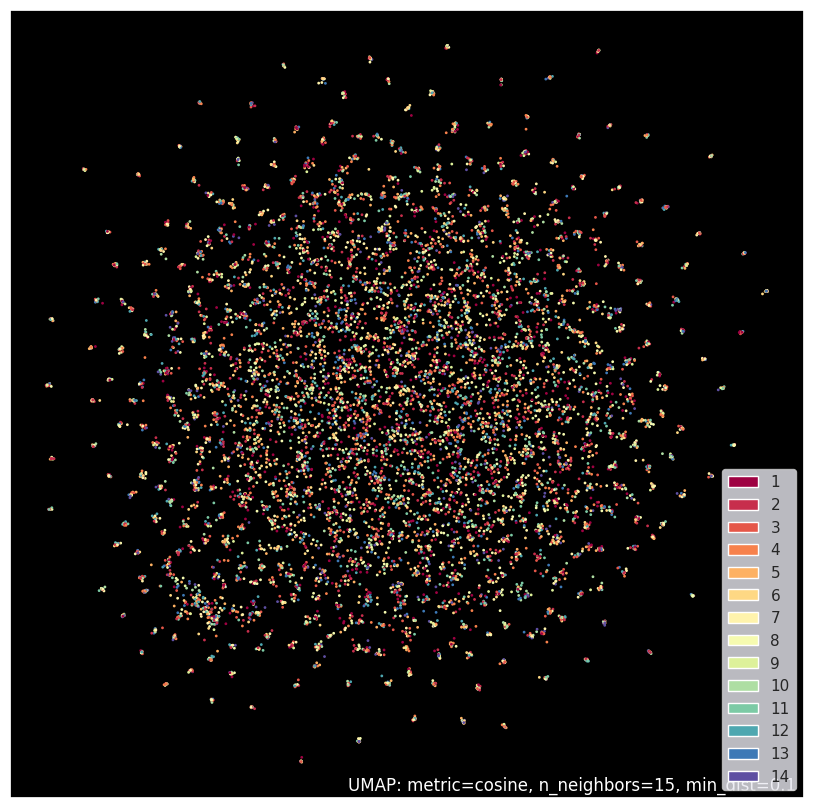

In [47]:
import matplotlib._color_data as mcd
palette = list(mcd.XKCD_COLORS.values())[::20]

umap.plot.points(
    bow_vertex_mapper,
    labels=np.array(vertex_labels),
    background="black",
    width=1024,
    height=1024,
);

In [48]:
%%time
info_transformer = vectorizers.transformers.InformationWeightTransformer(
    prior_strength=1e-1,
    approx_prior=False,
)
info_vertex_vectors = info_transformer.fit_transform(bow_vertex_vectors)

CPU times: user 9.71 s, sys: 284 ms, total: 9.99 s
Wall time: 2.37 s


In [ ]:
%%time
info_vertex_mapper = umap.UMAP(metric="cosine", random_state=42).fit(info_vertex_vectors)

In [ ]:
import matplotlib._color_data as mcd
palette = list(mcd.XKCD_COLORS.values())[::20]

umap.plot.points(
    info_vertex_mapper,
    labels=np.array(vertex_labels),
    background="black",
    width=1024,
    height=1024,
);

In [ ]:
he_vectors.shape

In [ ]:
bow_vertex_vectors.shape

In [37]:
%%time
awe_vertex_vectorizer = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.66,
    random_state=42,
)
awe_vertex_vectors = awe_vertex_vectorizer.fit_transform(bow_vertex_vectors, vectors=he_vectors)

ValueError: dimension mismatch

In [38]:
%%time
awe_vertex_mapper = umap.UMAP(metric="cosine", random_state=42).fit(awe_vertex_vectors)

NameError: name 'awe_vertex_vectors' is not defined

NameError: name 'awe_vertex_mapper' is not defined

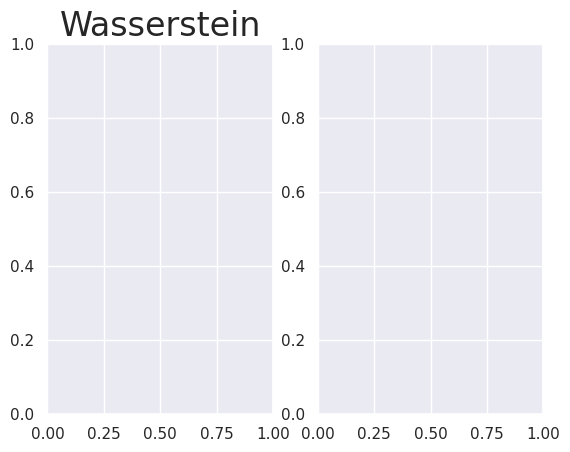

In [39]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2) #create the axes

axs[0].set_title("Wasserstein", fontsize=24)
p = umap.plot.points(
    awe_vertex_mapper,
    labels=np.array(vertex_labels),
    background="black",
    width=1024,
    height=1024,
    show_legend=False,
    ax=axs[0]
);

axs[1].set_axis_off() #turn off the axis
legend_label = [w.get_text() for w in list(p.legend_.get_texts())]
ax.legend(handles = p.legend_.legendHandles, labels = legend_label) #legend alone in the figure
fig.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


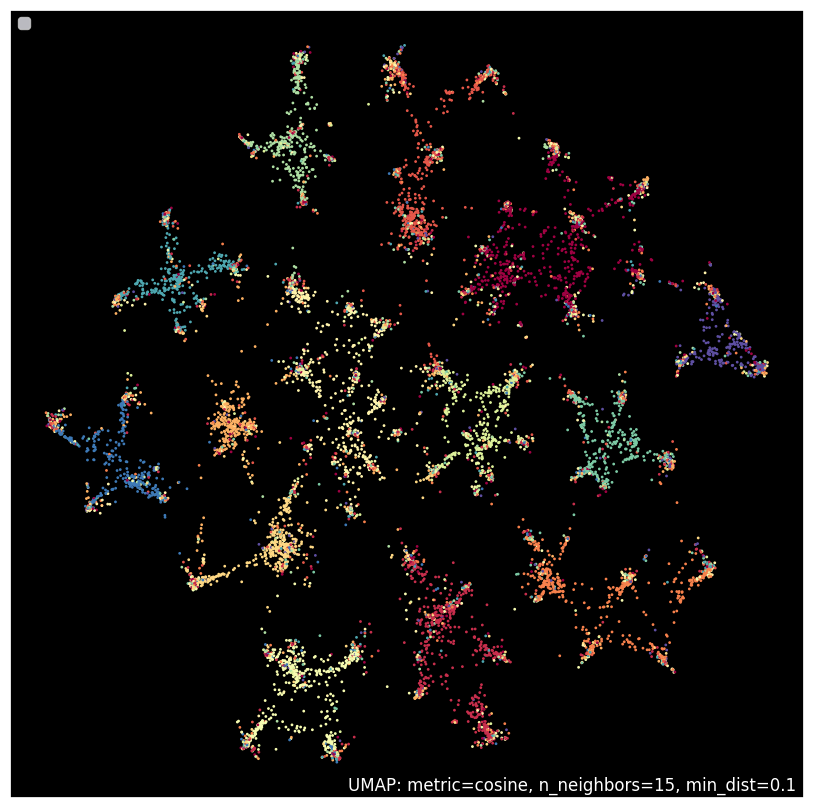

In [25]:
import matplotlib._color_data as mcd
palette = list(mcd.XKCD_COLORS.values())[::20]

p = umap.plot.points(
    awe_vertex_mapper,
    labels=np.array(vertex_labels),
    background="black",
    width=1024,
    height=1024,
);
p.legend(loc='upper left')

# Downstream task

In [26]:
import sklearn.model_selection
import sklearn.ensemble
import sklearn.linear_model
import sklearn.neural_network
import sklearn.neighbors

from sklearn.experimental import enable_hist_gradient_boosting

In [27]:
cooc_8 = sklearn.decomposition.TruncatedSVD(n_components=8, n_iter=20).fit_transform(vertex_vectors)
# tfidf_vertex_matrix = sklearn.feature_extraction.text.TfidfTransformer().fit_transform(bow_vertex_vectors)
bow_8 = sklearn.decomposition.TruncatedSVD(n_components=8, n_iter=20).fit_transform(bow_vertex_vectors)
# tfidf_8 = sklearn.decomposition.TruncatedSVD(n_components=8, n_iter=20).fit_transform(tfidf_vertex_matrix)
info_8 = sklearn.decomposition.TruncatedSVD(n_components=8, n_iter=20).fit_transform(info_vertex_vectors)

In [40]:
def cross_validate(model, data, recipes_label, n_splits=20, test_ratio=0.1, random_seed=42):
    splitter = sklearn.model_selection.ShuffleSplit(
        n_splits=n_splits, test_size=test_ratio, random_state=random_seed
    )
    result = sklearn.model_selection.cross_val_score(model, data, recipes_label, cv=splitter)
    return result

def cross_validation_dataframe(model, feature_sets, recipes_label, n_splits=20, test_ratio=0.1, random_seed=42):
    dfs = []
    for feature_space_name, feature_space in feature_sets.items():
        cv_scores = cross_validate(model, feature_space, recipes_label, n_splits, test_ratio, random_seed)
        feature_df = pd.DataFrame(
            {
                "run" : np.arange(n_splits), 
                "Embedding" : feature_space_name,
                "Model" : model.__repr__().split("(")[0],
                "Accuracy" : cv_scores
            }
        )
        dfs.append(feature_df)
    return pd.concat(dfs)

In [41]:
models = [
    sklearn.neighbors.KNeighborsClassifier(metric="cosine", n_neighbors=5, weights="distance"),
    # sklearn.ensemble.HistGradientBoostingClassifier(),
    sklearn.ensemble.RandomForestClassifier(),
    # sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(20, 10, 15))
]
feature_sets = {
    "Co-occurences": cooc_8,
    "Counts": bow_8,
    "InfoWeighted": info_8,
    "A-Wasserstein": awe_vertex_vectors,
    # "Supervised-A-Wasserstein": lat_vectors_supervised,
}

In [42]:
%%time
results = []
for model in models:
    print(model)
    res = cross_validation_dataframe(
        model, 
        feature_sets,
        vertex_labels,
    )
    results.append(res)

df_all = pd.concat( results )

KNeighborsClassifier(metric='cosine', weights='distance')
CPU times: user 7min 32s, sys: 14.4 s, total: 7min 46s
Wall time: 5min 44s


In [43]:
df = df_all

In [44]:
# pourquoi toutes les accuracies sont des multiples de 10? Parce qu'on ne testait que 10 points (sur 100).
# pourquoi il n'y a pas de résultat de MLP pour Wasserstein?

In [47]:
# df[df.Embedding=='InfoWeighted']

,run,Embedding,Model,Accuracy
0,0,InfoWeighted,KNeighborsClassifier,0.453
1,1,InfoWeighted,KNeighborsClassifier,0.432
2,2,InfoWeighted,KNeighborsClassifier,0.422
3,3,InfoWeighted,KNeighborsClassifier,0.443
4,4,InfoWeighted,KNeighborsClassifier,0.464
5,5,InfoWeighted,KNeighborsClassifier,0.435
6,6,InfoWeighted,KNeighborsClassifier,0.417
7,7,InfoWeighted,KNeighborsClassifier,0.453
8,8,InfoWeighted,KNeighborsClassifier,0.428
9,9,InfoWeighted,KNeighborsClassifier,0.474


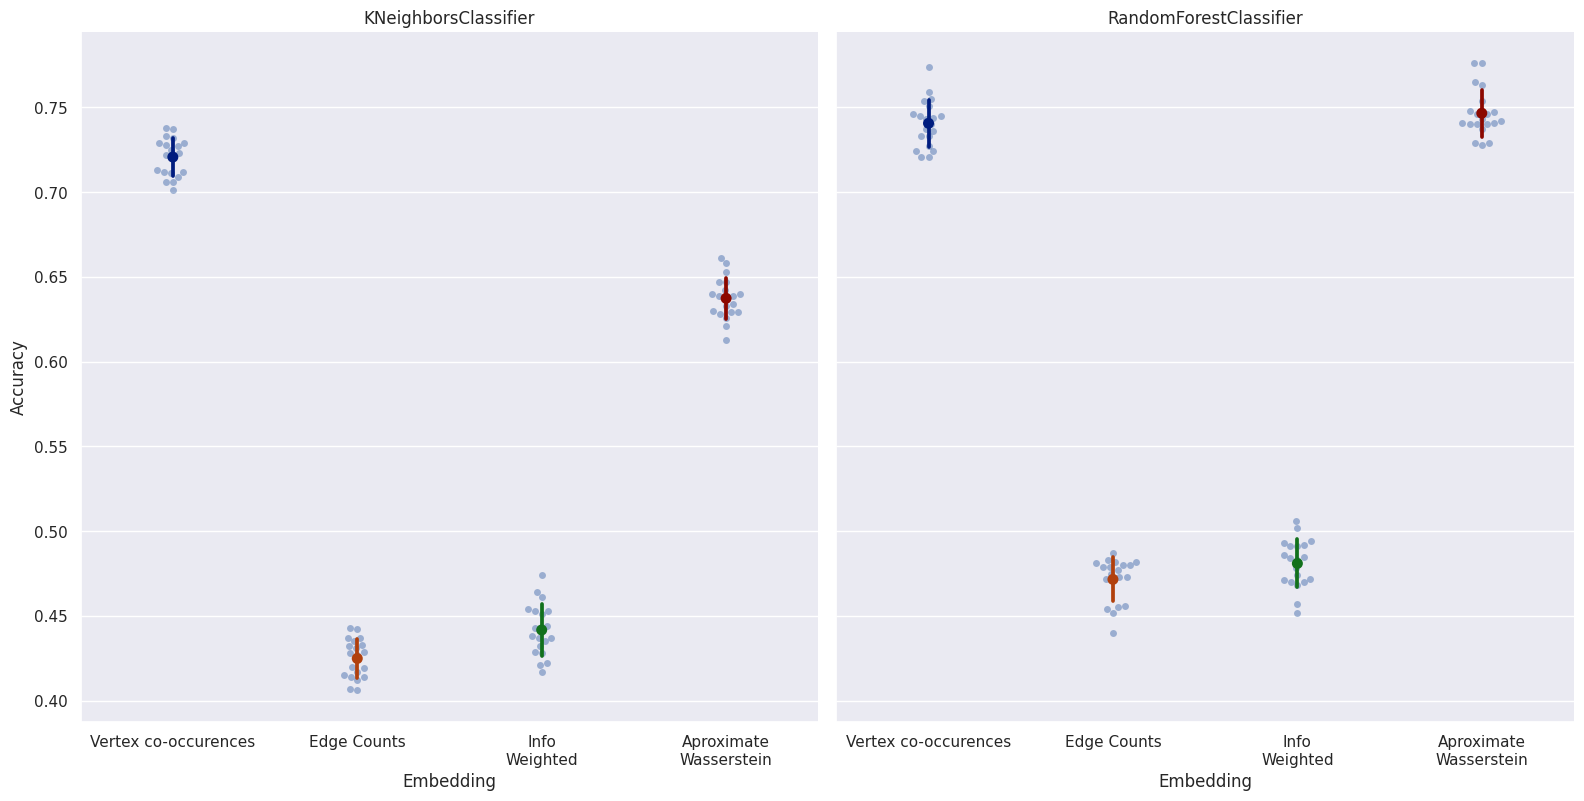

In [48]:
g = sns.catplot(
    kind="swarm", 
    x="Embedding", 
    y="Accuracy", 
    col="Model",
    col_wrap=2,
    # data=df[df.Accuracy >= 0.5],
    data = df,
    height=8, 
    alpha=0.5,
    zorder=1,
)
g.map_dataframe(
    sns.pointplot, 
    x="Embedding", 
    y="Accuracy", 
    color="Model", 
    data = df,
    # data=df[df.Accuracy >= 0.5], 
    # height=6, 
    # aspect=1.3,
    palette="dark",
    join=False,
    order=[
        "Co-occurences",
        "Counts", 
        "InfoWeighted", 
        "A-Wasserstein"
    ],
    ci="sd",
    # zorder=2,
    scale=0.9,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels([
    "Vertex co-occurences",
    "Edge Counts", 
    "Info\nWeighted", 
    "Aproximate\nWasserstein"
])
# g.savefig("figures/recipe_embedding_comparison_downstream_task.png", facecolor="none")